In [1]:

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from pylab import rcParams
import torch.optim as optim
import torch
from typing import List
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm.notebook import tqdm
from torchsummary import summary
from torch.nn.utils.rnn import pad_sequence
import networkx as nx
from mlxtend.frequent_patterns import apriori,association_rules
from mlxtend.preprocessing import TransactionEncoder
import seaborn as sns
import collections


In [35]:
# df = pd.read_csv('/content/train_set.csv')


df_train = pd.read_csv('/content/sample_data/train_set.csv').set_index('utrip_id')
# df_train.index = df_train.index.values.astype(int)
df_test = pd.read_csv('/content/sample_data/test_set.csv').set_index('utrip_id')
df_ground_truth = pd.read_csv('/content/sample_data/ground_truth.csv').set_index('utrip_id')


In [36]:
df_train.head()

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country
utrip_id,,,,,,,,
1000027_1,1000027,2016-08-13,2016-08-14,8183,desktop,7168,Elbonia,Gondal
1000027_1,1000027,2016-08-14,2016-08-16,15626,desktop,7168,Elbonia,Gondal
1000027_1,1000027,2016-08-16,2016-08-18,60902,desktop,7168,Elbonia,Gondal
1000027_1,1000027,2016-08-18,2016-08-21,30628,desktop,253,Elbonia,Gondal
1000033_1,1000033,2016-04-09,2016-04-11,38677,mobile,359,Gondal,Cobra Island


In [29]:
df_test = df_test.merge(df_ground_truth, left_on='utrip_id', right_on='utrip_id')
df_test.index = df_test.index.astype(int)
df_test['city_id'] = np.where(df_test['city_id_x'] == 0, df_test['city_id_y'], df_test['city_id_x'])
df_test = df_test[['user_id','checkin','checkout','device_class','affiliate_id','booker_country', 'city_id']]

In [30]:
df_test

,user_id,checkin,checkout,device_class,affiliate_id,booker_country,city_id
utrip_id,,,,,,,
10000662,1000066,2016-07-21,2016-07-23,desktop,9924,Gondal,56430
10000662,1000066,2016-07-23,2016-07-25,desktop,9924,Gondal,41971
10000662,1000066,2016-07-25,2016-07-28,desktop,9924,Gondal,5797
10000662,1000066,2016-07-28,2016-07-31,mobile,2436,Gondal,11543
10002701,1000270,2016-02-08,2016-02-09,mobile,9452,The Devilfire Empire,50075
...,...,...,...,...,...,...,...
9999111,999911,2016-10-07,2016-10-08,desktop,9598,Gondal,29319
9999913,999991,2016-08-15,2016-08-17,desktop,8065,Elbonia,29770
9999913,999991,2016-08-18,2016-08-19,desktop,8065,Elbonia,36170


In [31]:
df_train.head(10)
# print(df.shape)

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country
10000271,1000027,2016-08-13,2016-08-14,8183,desktop,7168,Elbonia,Gondal
10000271,1000027,2016-08-14,2016-08-16,15626,desktop,7168,Elbonia,Gondal
10000271,1000027,2016-08-16,2016-08-18,60902,desktop,7168,Elbonia,Gondal
10000271,1000027,2016-08-18,2016-08-21,30628,desktop,253,Elbonia,Gondal
10000331,1000033,2016-04-09,2016-04-11,38677,mobile,359,Gondal,Cobra Island
10000331,1000033,2016-04-11,2016-04-12,52089,desktop,384,Gondal,Cobra Island
10000331,1000033,2016-04-12,2016-04-14,21328,desktop,384,Gondal,Cobra Island
10000331,1000033,2016-04-14,2016-04-16,27485,desktop,384,Gondal,Cobra Island
10000331,1000033,2016-04-16,2016-04-19,38677,desktop,384,Gondal,Cobra Island
10000451,1000045,2016-06-18,2016-06-20,64876,desktop,2790,The Devilfire Empire,Fook Island


In [16]:
#Unique features 
features = ["user_id", "city_id", "affiliate_id", "booker_country", "hotel_country"]
for i in range(len(features)):
    len_features = len(df_train[features[i]].unique())
    print(f"There are {len_features} {features[i]}")


There are 147082 user_id
There are 36092 city_id
There are 2843 affiliate_id
There are 6 booker_country
There are 194 hotel_country


In [23]:
df_train.columns

Index(['user_id', 'checkin', 'checkout', 'city_id', 'device_class',
       'affiliate_id', 'booker_country', 'hotel_country'],
      dtype='object')

In [26]:
df_train.head(

)

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country
10000271,1000027,2016-08-13,2016-08-14,8183,desktop,7168,Elbonia,Gondal
10000271,1000027,2016-08-14,2016-08-16,15626,desktop,7168,Elbonia,Gondal
10000271,1000027,2016-08-16,2016-08-18,60902,desktop,7168,Elbonia,Gondal
10000271,1000027,2016-08-18,2016-08-21,30628,desktop,253,Elbonia,Gondal
10000331,1000033,2016-04-09,2016-04-11,38677,mobile,359,Gondal,Cobra Island


In [25]:
# strip_count = df_train["utrip_id"].value_counts()
strip_count = df_train.index.value_counts()
strip_count

36354313     48
220926510    45
4331888      44
220926515    41
52311403     41
             ..
54755291      1
1992971       1
58687871      1
38748223      1
30036651      1
Length: 217684, dtype: int64

In [39]:
# Plot the histogram to find out the distribution of how many times customers mostly book?
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
import numpy as np

hist, edges = np.histogram(strip_count, bins=48)
# Create the blank plot
p = figure(plot_height = 600, plot_width = 600, 
           title = 'Histogram of Area',
          x_axis_label = 'Area', 
           y_axis_label = 'Count')

# Add a quad glyph
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="white")

# Show the plot
output_notebook()
show(p)

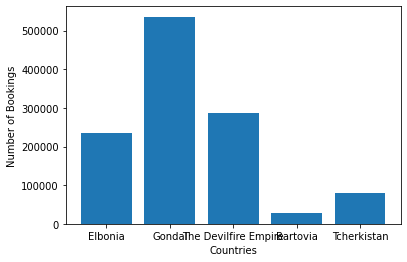

In [40]:
#Countries with maximun number of bookings 

from collections import Counter

c = Counter(df_train['booker_country'])
fig = plt.bar(c.keys(), c.values())
plt.xlabel('Countries')
plt.ylabel('Number of Bookings')
plt.show()

In [41]:
city_count = df_train["city_id"].value_counts()
city_count[0:15]

47499    11242
23921    10511
36063     9559
17013     9011
29319     8179
64876     7784
55128     7763
17127     6893
2416      6641
66648     6625
60222     6278
51259     6093
29770     6088
26235     5818
48483     5731
Name: city_id, dtype: int64

In [42]:
# Ranked which months customers travel the most?
ctry_count = df_train["hotel_country"].value_counts()
ctry_count[0:15]

Cobra Island              137791
Fook Island               117717
Gondal                    104979
Glubbdubdrib               74840
Elbonia                    53965
Borginia                   45629
Kangan                     44876
Bozatta                    40599
Alvonia                    34446
Holy Britannian Empire     30040
Axphain                    28719
Santa Prisca               27546
Patusan                    26088
Rolisica                   22338
Kasnia                     21588
Name: hotel_country, dtype: int64

In [43]:
# List of cities travels the most
booker_country_count = df_train["booker_country"].value_counts()
booker_country_count

Gondal                  536036
The Devilfire Empire    286244
Elbonia                 235344
Tcherkistan              80573
Bartovia                 28638
Name: booker_country, dtype: int64

In [ ]:
pip install pandas-profiling

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
report = ProfileReport(df_train)
report

In [45]:
# Day of Week and Length of Trip
from collections import Counter

In [ ]:
# c = Counter(df['city_id'])
# city_trips = list(sorted(c.values(), reverse=True))
# city_trips_cdf = np.cumsum(city_trips) / sum(city_trips)

# plt.plot(city_trips_cdf)
# plt.xlim(0, 20000)
# plt.ylim(0, 1)
# plt.xlabel('Number of Cities')
# plt.ylabel('Proportion of Trips Covered (CDF)')
# plt.grid(color='grey', linestyle='--', linewidth=1)
# plt.show()

In [51]:
def preprocess_label_df(
        df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''
    adds label to the dataset 
    removes the last row for every trip
    removes sequences shorter than 3
    order the df starting from longer sequences
    '''
    df_chunks = []
    df['label'] = df['city_id'].shift(-1)
    idx_labels = np.unique(df.index)

    for idx in tqdm(idx_labels):
        temp_dataset = df.loc[idx].head(-1)
        if type(temp_dataset) == pd.DataFrame and len(temp_dataset) >= 3:
            df_chunks.append(temp_dataset)

    df_chunks = sorted(df_chunks, key=lambda x: len(x), reverse=True)
    new_df = pd.concat(df_chunks)

    return new_df


def front_padding_sequence(tensors: List, num_features: int) -> torch.Tensor:
    """
    Applies front padding to a list of tensors
    """
    sizes = [len(tensor) for tensor in tensors]
    max_size = max(sizes)
    pad_tensors = []
    for q in tensors:
        new_tensor = torch.zeros(max_size, num_features)
        new_tensor[max_size - len(q):] = q
        pad_tensors.append(new_tensor)

    return torch.stack(pad_tensors, dim=0).long()


def custom_padding(batch):
    '''
    pad each batch according to the sequence 
    with the highest length
    '''
    features = [sample[0] for sample in batch]
    features = front_padding_sequence(features, 2)
    labels = [sample[1].unsqueeze(dim=1) for sample in batch]
    labels = front_padding_sequence(labels, 1)

    return features, labels

In [52]:
df_train = preprocess_label_df(df_train)
df_test = preprocess_label_df(df_test)

  0%|          | 0/217684 [00:00<?, ?it/s]

  0%|          | 0/70662 [00:00<?, ?it/s]

In [53]:
### Change utrip_id label
df_train['label'] = df_train['label'].astype(int)
df_test['label'] = df_test['label'].astype(int)

In [54]:
utrip_distinct_train = df_train.index.unique()
utrip_train_map = {utrip:i for i, utrip in enumerate(utrip_distinct_train)}
df_train = df_train.rename(index=utrip_train_map)

utrip_distinct_test = df_test.index.unique()
utrip_test_map = {utrip:i for i, utrip in enumerate(utrip_distinct_test)}
df_test = df_test.rename(index=utrip_test_map)

In [55]:
df_train.head()

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,label
0,3635431,2016-04-01,2016-04-02,47319,mobile,9924,Gondal,Gondal,36063
0,3635431,2016-04-02,2016-04-03,36063,mobile,9924,Gondal,Gondal,36063
0,3635431,2016-04-03,2016-04-04,36063,mobile,384,Gondal,Gondal,36063
0,3635431,2016-04-04,2016-04-05,36063,mobile,9924,Gondal,Gondal,3109
0,3635431,2016-04-05,2016-04-06,3109,mobile,9924,Gondal,Gondal,3109


In [56]:
##### Create map for data

distinct_affiliate_id = np.unique(df_train.affiliate_id)
affiliate_id_map = {aff_id:i+1 for i, aff_id in enumerate(distinct_affiliate_id)}

distinct_checkin_id = np.unique(df_train.checkin)
checkin_map = {checkin:i+1 for i, checkin in enumerate(distinct_checkin_id)}

distinct_device_class = np.unique(df_train.device_class)
device_map = {device:i+1 for i, device in enumerate(distinct_device_class)}

distinct_city_id = np.unique([df_train.city_id,df_train.label])
city_id_map = {city_id:i+1 for i, city_id in enumerate(distinct_city_id)}

distinct_booker_country = np.unique(df_train.booker_country)
booker_country_map = {booker_country:i+1 for i, booker_country in enumerate(distinct_booker_country)}

distinct_hotel_country = np.unique(df_train.hotel_country.astype(str))
hotel_country_map = {hotel_country:i+1 for i, hotel_country in enumerate(distinct_hotel_country)}

In [57]:
df_train['checkin'] = df_train['checkin'].map(lambda x: checkin_map.get(x))
df_train['affiliate_id'] = df_train['affiliate_id'].map(lambda x: affiliate_id_map.get(x))
df_train['city_id'] = df_train['city_id'].map(lambda x: city_id_map.get(x))
df_train['label'] = df_train['label'].map(lambda x: city_id_map.get(x))
df_train['booker_country'] = df_train['booker_country'].map(lambda x: booker_country_map.get(x))

In [58]:
df_test['checkin'] = df_test['checkin'].map(lambda x: checkin_map.get(x, 0))
df_test['affiliate_id'] = df_test['affiliate_id'].map(lambda x: affiliate_id_map.get(x, 0))
df_test['city_id'] = df_test['city_id'].map(lambda x: city_id_map.get(x, 0))
df_test['label'] = df_test['label'].map(lambda x: city_id_map.get(x, 0))
df_test['booker_country'] = df_test['booker_country'].map(lambda x: booker_country_map.get(x, 0))

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [60]:
#Create dataset

In [61]:
class BookingDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return max(self.df.index)
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        city_id = row['city_id'].values
        label_id = row['label'].values
        affiliate_id = row['affiliate_id']
        
        city_id = torch.tensor(row['city_id'].values).view(-1, 1)
        affiliate_id = torch.tensor(row['affiliate_id'].values).view(-1, 1)
        features = torch.cat((city_id, affiliate_id), 1)
        features = features.view(-1, 2)
        
        label_id = torch.tensor(row['label'].values).float()
        
        return features, label_id

In [62]:
train_ds = BookingDataset(df_train)
train_dl = DataLoader(train_ds, batch_size = 4, shuffle = False, collate_fn=custom_padding)
test_ds = BookingDataset(df_test)
test_dl = DataLoader(test_ds, batch_size = 4, shuffle = False, collate_fn=custom_padding)

In [63]:
#LSTM

class LSTM(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.city_emb = nn.Embedding(len(city_id_map)+1, emb_size, padding_idx=0)
        self.affiliate_emb = nn.Embedding(len(affiliate_id_map)+1, emb_size, padding_idx=0)
        self.lstm = nn.LSTM(emb_size*2, hidden_size, batch_first=True)
        self.g = nn.Linear(hidden_size, len(city_id_map)+1)
        
    def forward(self, x):
        city_emb = self.city_emb(x[:,:,0])
        affiliate_emb = self.affiliate_emb(x[:,:,1])
        x = torch.cat((city_emb, affiliate_emb), dim=2)
        out, hidden = self.lstm(x)
        out = self.g(out) 
        return out, hidden

In [64]:
lstm = LSTM(50, 100)
lstm.to(device)

LSTM(
  (city_emb): Embedding(39879, 50, padding_idx=0)
  (affiliate_emb): Embedding(3089, 50, padding_idx=0)
  (lstm): LSTM(100, 100, batch_first=True)
  (g): Linear(in_features=100, out_features=39879, bias=True)
)

In [65]:
loss_fun = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(lstm.parameters(), lr = 0.01)

In [66]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):

    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        output, hidden = model(x)
        if output.shape[1] >= 3:
          output = output[:, 2:, :]
          y_ = y[:, 2:, :]
          output = output.transpose(1,2)
          loss = lossFun(output, y_.squeeze(2))
          total_loss += loss.item()
        else:
          continue
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

In [67]:
def one_pass_acc4(model, dataloader, num_points, k=4, is_train=True):
    model.eval()
    total_correct = 0
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        output, hidden = model(x)
        # print(y.shape)
        # print(output.shape)
        if is_train:
          output = output[:,2:,:]
          y_ = y[:, 2:,: ]
        else:
          output = output[:,-1:,:]
          y_ = y[:, -1:, :]
        # print(output.shape)
        result = torch.topk(output, 4)
        idx = result.indices
        matches = (torch.eq(idx, y_).sum(2)>0).sum(1)>0
        correct = matches.sum().item()
        total_correct += correct
        
    return (total_correct/num_points)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}")
  train_loss = one_pass(lstm, train_dl, optimizer, loss_fun)
  print(f"Train Loss: {train_loss:.4f}")
  test_loss = one_pass(lstm, test_dl, optimizer, loss_fun, backwards=False)
  print(f"Test Loss: {test_loss:.4f}")
  train_acc = one_pass_acc4(lstm, train_dl, len(train_ds), k=4)
  print(f"Train Accuracy: {train_acc:.4f}")
  test_acc = one_pass_acc4(lstm, test_dl, len(test_ds), k=4, is_train=False)
  print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1


  0%|          | 0/54201 [00:00<?, ?it/s]

In [ ]:
one_pass_acc4(lstm, train_dl, len(train_ds))

In [ ]:
test_ds = BookingDataset(df_test)
test_dl = DataLoader(test_ds, batch_size = 4, shuffle = False, collate_fn=custom_padding)
one_pass_acc4(lstm, test_dl, len(test_ds))

In [70]:
import matplotlib.pyplot as plt

plt.plot(lstm.history['train_loss'], label='Train loss')
plt.plot(lstm.history['test_loss'], label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
plt.plot(lstm.history['train_acc'], label='Train accuracy')
plt.plot(lstm.history['test_acc'], label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

AttributeError: ignored